In [1]:
import os
import time
import glob
import calendar
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
%matplotlib inline

In [2]:
df_data = pd.read_csv('secom.data', sep="\s+",header=None)
df_target = pd.read_csv('secom_labels.data', sep="\s+",header=None)
df_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,-0.0034,0.9455,202.4396,0.0,7.9558,414.8710,10.0433,0.9680,192.3963,12.5190,1.4026,-5419.00,2916.50,-4043.75,751.00,0.8955,1.7730,3.0490,64.2333,2.0222,0.1632,3.5191,83.3971,9.5126,50.6170,64.2588,49.3830,66.3141,86.9555,117.5132,...,12.93,0.78,0.1827,5.7349,0.3363,39.8842,3.2687,1.0297,1.0344,0.4385,0.1039,42.3877,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,533.8500,2.1113,8.95,0.3157,3.0624,0.1026,1.6765,14.9509,NaN,NaN,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,-0.0148,0.9627,200.5470,0.0,10.1548,414.7347,9.2599,0.9701,191.2872,12.4608,1.3825,-5441.50,2604.25,-3498.75,-1640.25,1.2973,2.0143,7.3900,68.4222,2.2667,0.2102,3.4171,84.9052,9.7997,50.6596,64.2828,49.3404,64.9193,87.5241,118.1188,...,16.00,1.33,0.2829,7.1196,0.4989,53.1836,3.9139,1.7819,0.9634,0.1745,0.0375,18.1087,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,535.0164,2.4335,5.92,0.2653,2.0111,0.0772,1.1065,10.9003,0.0096,0.0201,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,0.0013,0.9615,202.0179,0.0,9.5157,416.7075,9.3144,0.9674,192.7035,12.5404,1.4123,-5447.75,2701.75,-4047.00,-1916.50,1.3122,2.0295,7.5788,67.1333,2.3333,0.1734,3.5986,84.7569,8.6590,50.1530,64.1114,49.8470,65.8389,84.7327,118.6128,...,16.16,0.85,0.0857,7.1619,0.3752,23.0713,3.9306,1.1386,1.5021,0.3718,0.1233,24.7524,267.064,0.9032,1.10,0.6219,0.4122,0.2562,0.4119,68.8489,535.0245,2.0293,11.21,0.1882,4.0923,0.0640,2.0952,9.2721,0.0584,0.0484,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,-0.0033,0.9629,201.8482,0.0,9.6052,422.2894,9.6924,0.9687,192.1557,12.4782,1.4011,-5468.25,2648.25,-4515.00,-1657.25,1.3137,2.0038,7.3145,62.9333,2.6444,0.2071,3.3813,84.9105,8.6789,50.5100,64.1125,49.4900,65.1951,86.6867,117.0442,...,131.68,39.33,0.6812,56.9303,17.4781,161.4081,35.3198,54.2917,1.1613,0.7288,0.2710,62.7572,268.228,0.6511,7.32,0.1630,3.5611,0.0670,2.7290,25.0363,530.5682,2.0253,9.33,0.1738,2.8971,0.0525,1.7585,8.5831,0.0202,0.0149,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,-0.0072,0.9569,201.9424,0.0,10.5661,420.5925,10.3387,0.9735,191.6037,12.4735,1.3888,-5476.25,2635.25,-3987.50,117.00,1.2887,1.9912,7.2748,62.8333,3.1556,0.2696,3.2728,86.3269,8.7677,50.2480,64.1511,49.7520,66.1542,86.1468,121.4364,...,19.63,1.98,0.4287,9.7608,0.8311,70.9706,4.9086,2.5014,0.9778,0.2156,0.0461,22.0500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,532.0155,2.0275,8.83,0.2224,3.1776,0.0706,1.6597,10.9698,NaN,NaN,NaN,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432


In [3]:
df_target.head()

,0,1
0,-1,19/07/2008 11:55:00
1,-1,19/07/2008 12:32:00
2,1,19/07/2008 13:17:00
3,-1,19/07/2008 14:43:00
4,-1,19/07/2008 15:22:00


In [4]:
df_data.shape, df_target.shape

((1567, 590), (1567, 2))

In [5]:
df_target.iloc[:,1]

# Drop date cols
df_target.drop([1], axis=1,inplace=True)
df_target.rename(columns = {list(df_target)[0]:'Target'}, inplace=True)

In [6]:
df_target.head()

,Target
0,-1
1,-1
2,1
3,-1
4,-1


In [7]:
# Convert all Fails(1) to -1 
for i, val in enumerate(df_target.Target):
    if val == 1:
        df_target.iloc[i,0] = 0

for i, val in enumerate(df_target.Target):
    if val == -1:
        df_target.iloc[i,0] = 1
df_target.head() 

,Target
0,1
1,1
2,0
3,1
4,1


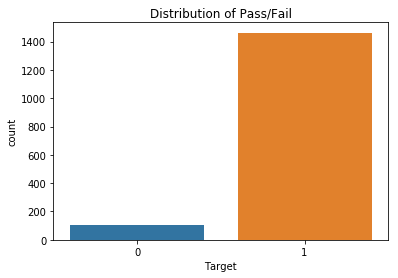

In [8]:
plt.figure()
sns.countplot(df_target.Target)
plt.title('Distribution of Pass/Fail')
plt.show()

## Have a look at all data

In [9]:
df = pd.concat([df_data, df_target], axis=1)

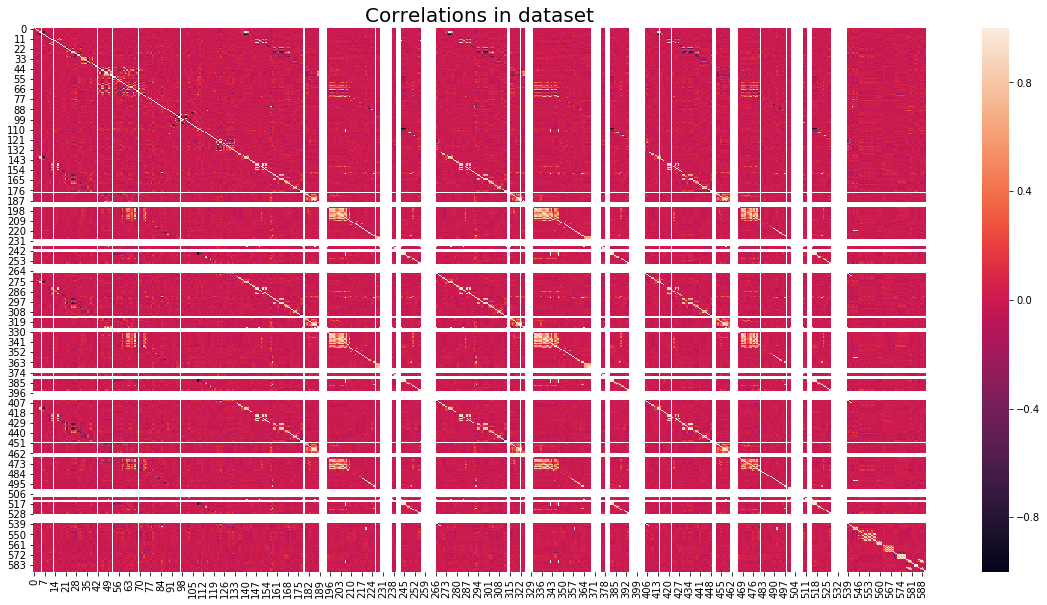

In [10]:
correlation = df.corr()

f, ax = plt.subplots(figsize=(20,10))
plt.title('Correlations in dataset', size=20)
sns.heatmap(correlation)
plt.show()

### Dealing with missing values

In [11]:
missing_val_count_by_column = (df_data.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

0        6
1        7
2       14
3       14
4       14
5       14
6       14
7        9
8        2
9        2
10       2
11       2
12       2
13       3
14       3
15       3
16       3
17       3
18       3
19      10
21       2
22       2
23       2
24       2
25       2
26       2
27       2
28       2
29       2
30       2
      ... 
552    260
553    260
554    260
555    260
556    260
557    260
558      1
559      1
560      1
561      1
562    273
563    273
564    273
565    273
566    273
567    273
568    273
569    273
578    949
579    949
580    949
581    949
582      1
583      1
584      1
585      1
586      1
587      1
588      1
589      1
Length: 538, dtype: int64


In [12]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer()
df_data_imputed = imputer.fit_transform(df_data)

Verify imputer transformation

In [13]:
missing_val_count_by_column = (pd.DataFrame(df_data_imputed).isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

Series([], dtype: int64)


## PCA

In [14]:
# Scale values
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(df_data_imputed)

In [15]:
from sklearn.decomposition import PCA
pca = PCA()
X_scaled_pca = pca.fit(X_scaled)

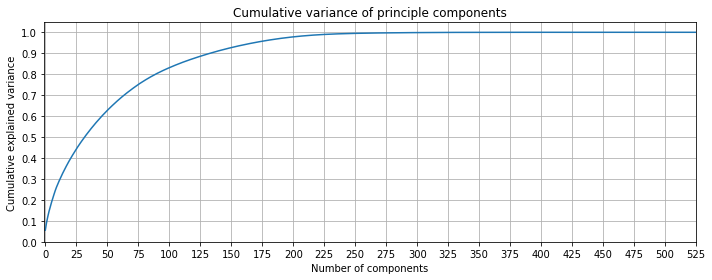

In [16]:
plt.figure(figsize=(10, 4))
axes= plt.axes()
axes.grid()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Cumulative variance of principle components')
plt.xticks(range(0,530,25))
plt.xlim(-1,525)
plt.yticks(np.arange(0,1.1,0.1))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.tight_layout()

The above plot shows almost 100% variance by the first 250 components

In [17]:
X = df_data
y = df_target

n_classes = y.shape[1]

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=4)


# Impute missing values
imputer = SimpleImputer()
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)
# Scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_test = y_test.values

In [19]:
X_train.shape,y_train.shape,y_test.shape

((1253, 590), (1253, 1), (314, 1))

In [20]:
def plot_roc(model,y_test,y_pred,title,label_auc):
    logit_roc_auc = roc_auc_score(y_test, model.predict(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label= label_auc+' (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()

In [21]:
def permutation_test_between_clfs(y_test, pred_proba_1, pred_proba_2, nsamples=1000):
    auc_differences = []
    auc1 = roc_auc_score(y_test.ravel(), pred_proba_1.ravel())
    auc2 = roc_auc_score(y_test.ravel(), pred_proba_2.ravel())
    observed_difference = auc1 - auc2
    for _ in range(nsamples):
        mask = np.random.randint(2, size=len(pred_proba_1.ravel()))
        p1 = np.where(mask, pred_proba_1.ravel(), pred_proba_2.ravel())
        p2 = np.where(mask, pred_proba_2.ravel(), pred_proba_1.ravel())
        auc1 = roc_auc_score(y_test.ravel(), p1)
        auc2 = roc_auc_score(y_test.ravel(), p2)
        auc_differences.append(auc1 - auc2)
    return print("difference in roc curves: {0:.4f} \nprobability to observe a larger difference on a shuffled data set: {1}".format(observed_difference, np.mean(auc_differences >= observed_difference)))


## Algorithm 1 - Logistic Regression

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from scipy import interp

start = time.time()

classifier = LogisticRegression(solver='sag', max_iter=4000, n_jobs=-1)
classifier.fit(X_train, np.ravel(y_train))
y_pred1 = classifier.predict(X_test)

end = time.time()
print("\nTime taken: {:.2f} seconds".format(end-start))


Time taken: 16.46 seconds


In [23]:
confusion_matrix = metrics.confusion_matrix(y_test,y_pred1)
confusion_matrix

array([[  6,  20],
       [ 10, 278]])

In [24]:
from sklearn.metrics import classification_report
auc_roc = metrics.classification_report(y_test,y_pred1)
print('Logistic Regression Classification Report:\n {}'.format(auc_roc))

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.23      0.29        26
           1       0.93      0.97      0.95       288

   micro avg       0.90      0.90      0.90       314
   macro avg       0.65      0.60      0.62       314
weighted avg       0.89      0.90      0.89       314



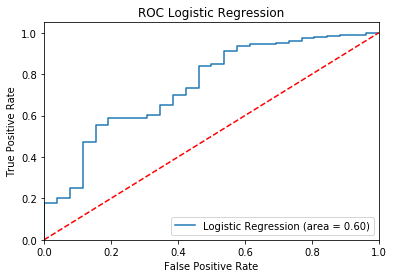

In [25]:
plot_roc(classifier,y_test, y_pred1, 'ROC Logistic Regression','Logistic Regression')

## Algorithm 2 - SVC

In [26]:
from sklearn.svm import SVC

start = time.time()

classifier = SVC(kernel="linear", probability=True, verbose=1)
classifier.fit(X_train, np.ravel(y_train))
y_pred2 = classifier.predict(X_test)

end = time.time()
print("\nTime taken: {:.2f} seconds".format(end-start))

[LibSVM]
Time taken: 2.70 seconds


In [27]:
confusion_matrix = metrics.confusion_matrix(y_test,y_pred2)
confusion_matrix

array([[  7,  19],
       [ 24, 264]])

In [28]:
auc_roc = metrics.classification_report(y_test, y_pred2)
print('SVC Classification Report:\n {}'.format(auc_roc))

SVC Classification Report:
               precision    recall  f1-score   support

           0       0.23      0.27      0.25        26
           1       0.93      0.92      0.92       288

   micro avg       0.86      0.86      0.86       314
   macro avg       0.58      0.59      0.59       314
weighted avg       0.87      0.86      0.87       314



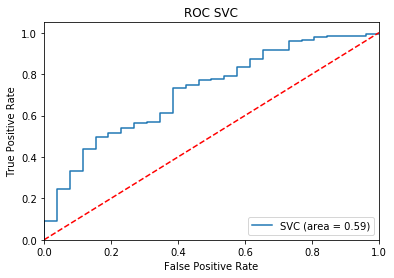

In [29]:
plot_roc(classifier,y_test, y_pred2, 'ROC SVC','SVC')

# Log Reg vs SVC permutation test

In [30]:

permutation_test_between_clfs(y_test, y_pred1, y_pred2, nsamples=1000)

difference in roc curves: 0.0051 
probability to observe a larger difference on a shuffled data set: 0.471


## Algorithm 1 w/Feature selection 1 - Logistic regression with Recursive Feature Elimination

In [31]:
from sklearn.feature_selection import RFE

start = time.time()

classifier = LogisticRegression(solver='sag', max_iter=4000, n_jobs=-1)
rfe = RFE(classifier,verbose=1,step=30)
rfe = rfe.fit(X_train, np.ravel(y_train))

end = time.time()
print("\nTime taken: {:.2f} seconds".format(end-start))

Fitting estimator with 590 features.
Fitting estimator with 560 features.
Fitting estimator with 530 features.
Fitting estimator with 500 features.
Fitting estimator with 470 features.
Fitting estimator with 440 features.
Fitting estimator with 410 features.
Fitting estimator with 380 features.
Fitting estimator with 350 features.
Fitting estimator with 320 features.

Time taken: 134.45 seconds


In [32]:
# Create new X train and test with est features from RFE
features = X.columns[rfe.support_]
print(features)
X_train_rfe = pd.DataFrame(X_train)[features]
X_test_rfe = pd.DataFrame(X_test)[features]

Int64Index([  0,   1,   2,   7,   8,   9,  10,  11,  14,  16,
            ...
            571, 574, 577, 578, 579, 580, 581, 582, 588, 589],
           dtype='int64', length=295)


In [33]:
classifier = LogisticRegression(solver='sag', max_iter=4000, n_jobs=-1)
classifier.fit(X_train_rfe, np.ravel(y_train))
y_pred11 = classifier.predict(X_test_rfe)

In [34]:
confusion_matrix = metrics.confusion_matrix(y_test,y_pred11)
confusion_matrix

array([[  7,  19],
       [  9, 279]])

In [35]:
auc_roc = metrics.classification_report(y_test,y_pred11)
print('Logistic Regression with RFE Classification Report:\n {}'.format(auc_roc))

Logistic Regression with RFE Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.27      0.33        26
           1       0.94      0.97      0.95       288

   micro avg       0.91      0.91      0.91       314
   macro avg       0.69      0.62      0.64       314
weighted avg       0.89      0.91      0.90       314



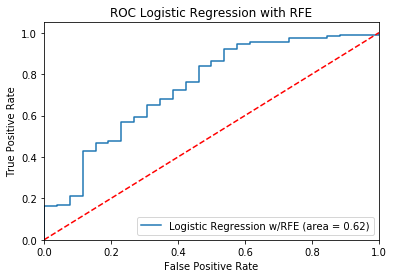

In [36]:
logit_roc_auc = roc_auc_score(y_test, classifier.predict(X_test_rfe))
fpr, tpr, thresholds = roc_curve(y_test, classifier.predict_proba(X_test_rfe)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression w/RFE (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Logistic Regression with RFE')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# Log Reg vs Log Reg w/RFE permutation test

In [37]:
permutation_test_between_clfs(y_test, y_pred1, y_pred11, nsamples=1000)

difference in roc curves: -0.0210 
probability to observe a larger difference on a shuffled data set: 1.0


## Algorithm 1 w/Feature selection 2 - Logistic regression with chi2 test

In [38]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import chi2 ,SelectKBest
norm = MinMaxScaler()

# Normalise training data 
X_train_norm = norm.fit_transform(X_train)

In [39]:
selector = SelectKBest(chi2, k=295)
selector.fit(X_train_norm, y_train)
X_train_kbest = selector.transform(X_train)
X_test_kbest = selector.transform(X_test)

In [40]:
classifier = LogisticRegression(solver='sag', max_iter=4000, n_jobs=-1)
classifier.fit(X_train_kbest, np.ravel(y_train))
y_pred12 = classifier.predict(X_test_kbest)

In [41]:
confusion_matrix = metrics.confusion_matrix(y_test,y_pred12)
confusion_matrix

array([[  2,  24],
       [  8, 280]])

In [42]:
auc_roc = metrics.classification_report(y_test,y_pred12)
print('Logistic Regression with chi2 test Classification Report:\n {}'.format(auc_roc))

Logistic Regression with chi2 test Classification Report:
               precision    recall  f1-score   support

           0       0.20      0.08      0.11        26
           1       0.92      0.97      0.95       288

   micro avg       0.90      0.90      0.90       314
   macro avg       0.56      0.52      0.53       314
weighted avg       0.86      0.90      0.88       314



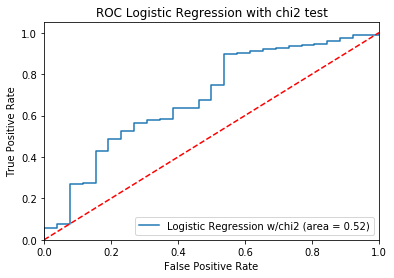

In [43]:
logit_roc_auc = roc_auc_score(y_test, classifier.predict(X_test_kbest))
fpr, tpr, thresholds = roc_curve(y_test, classifier.predict_proba(X_test_kbest)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression w/chi2 (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Logistic Regression with chi2 test')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# Log Reg vs Log Reg w/chi2 permutation test

In [44]:
permutation_test_between_clfs(y_test, y_pred1, y_pred12, nsamples=1000)

difference in roc curves: 0.0735 
probability to observe a larger difference on a shuffled data set: 0.064


## Algorithm 2 w/Feature selection 1 - SVC with RFE

In [45]:
start = time.time()

classifier = SVC(kernel="linear", probability=True, verbose=1)
rfe = RFE(classifier,verbose=1,step=30)
rfe = rfe.fit(X_train, np.ravel(y_train))

end = time.time()
print("\nTime taken: {:.2f} seconds".format(end-start))

Fitting estimator with 590 features.
[LibSVM]Fitting estimator with 560 features.
[LibSVM]Fitting estimator with 530 features.
[LibSVM]Fitting estimator with 500 features.
[LibSVM]Fitting estimator with 470 features.
[LibSVM]Fitting estimator with 440 features.
[LibSVM]Fitting estimator with 410 features.
[LibSVM]Fitting estimator with 380 features.
[LibSVM]Fitting estimator with 350 features.
[LibSVM]Fitting estimator with 320 features.
[LibSVM][LibSVM]
Time taken: 25.12 seconds


In [46]:
# Create new X train and test with est features from RFE
features = X.columns[rfe.support_]
print(features)
X_train_rfe = pd.DataFrame(X_train)[features]
X_test_rfe = pd.DataFrame(X_test)[features]

Int64Index([  0,   1,   7,   9,  10,  11,  15,  16,  18,  19,
            ...
            577, 578, 579, 580, 581, 582, 584, 587, 588, 589],
           dtype='int64', length=295)


In [47]:
classifier = SVC(kernel="linear", probability=True, verbose=1)
classifier.fit(X_train_rfe, np.ravel(y_train))
y_pred21 = classifier.predict(X_test_rfe)

[LibSVM]

In [48]:
confusion_matrix = metrics.confusion_matrix(y_test,y_pred21)
confusion_matrix

array([[  8,  18],
       [ 21, 267]])

In [49]:
auc_roc = metrics.classification_report(y_test,y_pred21)
print('SVC with RFE Classification Report:\n {}'.format(auc_roc))

SVC with RFE Classification Report:
               precision    recall  f1-score   support

           0       0.28      0.31      0.29        26
           1       0.94      0.93      0.93       288

   micro avg       0.88      0.88      0.88       314
   macro avg       0.61      0.62      0.61       314
weighted avg       0.88      0.88      0.88       314



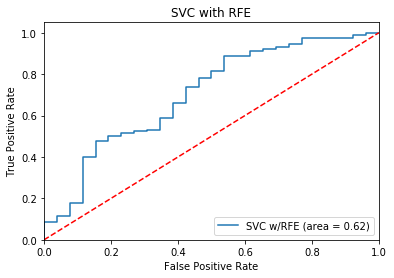

In [50]:
logit_roc_auc = roc_auc_score(y_test, classifier.predict(X_test_rfe))
fpr, tpr, thresholds = roc_curve(y_test, classifier.predict_proba(X_test_rfe)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='SVC w/RFE (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVC with RFE')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# SVC vs SVC w/RFE permutation test

In [51]:
permutation_test_between_clfs(y_test, y_pred2, y_pred21, nsamples=1000)

difference in roc curves: -0.0244 
probability to observe a larger difference on a shuffled data set: 0.987


## Algorithm 2 w/Feature selection 2 - SVC with chi2 test

In [52]:
norm = MinMaxScaler()

# Normalise training data 
X_train_norm = norm.fit_transform(X_train)

In [53]:
selector = SelectKBest(chi2, k=295)
selector.fit(X_train_norm, y_train)
X_train_kbest = selector.transform(X_train)
X_test_kbest = selector.transform(X_test)

In [54]:
classifier = SVC(kernel="linear", probability=True, verbose=1)
classifier.fit(X_train_kbest, np.ravel(y_train))
y_pred22 = classifier.predict(X_test_kbest)

[LibSVM]

In [55]:
confusion_matrix = metrics.confusion_matrix(y_test,y_pred22)
confusion_matrix

array([[  7,  19],
       [ 15, 273]])

In [56]:
auc_roc = metrics.classification_report(y_test,y_pred22)
print('SVC with chi2 test Classification Report:\n {}'.format(auc_roc))

SVC with chi2 test Classification Report:
               precision    recall  f1-score   support

           0       0.32      0.27      0.29        26
           1       0.93      0.95      0.94       288

   micro avg       0.89      0.89      0.89       314
   macro avg       0.63      0.61      0.62       314
weighted avg       0.88      0.89      0.89       314



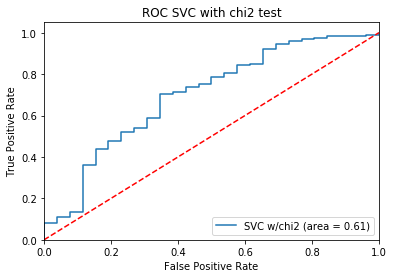

In [57]:
logit_roc_auc = roc_auc_score(y_test, classifier.predict(X_test_kbest))
fpr, tpr, thresholds = roc_curve(y_test, classifier.predict_proba(X_test_kbest)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='SVC w/chi2 (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC SVC with chi2 test')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# SVC vs SVC w/chi2 permutation test

In [58]:
permutation_test_between_clfs(y_test, y_pred2, y_pred22, nsamples=1000)

difference in roc curves: -0.0156 
probability to observe a larger difference on a shuffled data set: 0.668
